In [104]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [105]:
# Import the dataset and set the static variables
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

batch_size = 64
img_height = 224
img_width = 224

In [106]:
# Setting the training and validation datasets, using a split of 70% for training and 30% for validation as this is about testing the model's performance
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [107]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


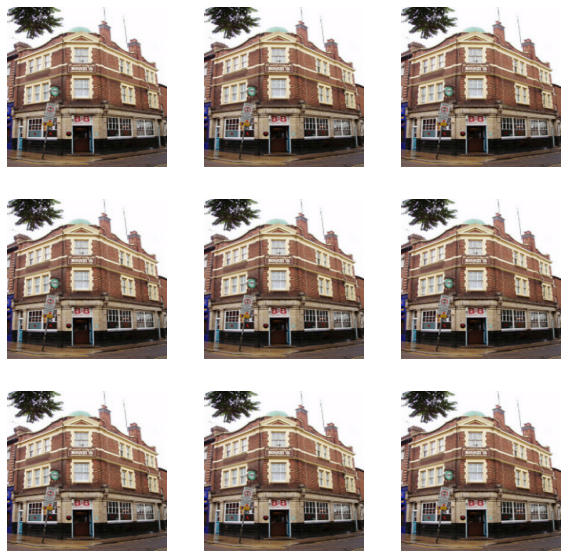

In [117]:
# TODO: get this working :(

from tensorflow import keras

# Randomly flipping the images horizontally and vertically, and randomly rotating the images slightly
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical", ),
    keras.layers.RandomRotation(25),
    keras.layers.RandomZoom(0.2),
  ]
)
# Displaying the first 9 images from the training dataset with the augmentation applied
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
  

Now all the data has been imported, here I will train the model

I'll be mostly following this guide [here](https://keras.io/guides/transfer_learning/) and this [here](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras) to help me along

In [109]:
# Importy required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [161]:
# Importing the model
mobileNet = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)

2/2 [==============================] - 0s 153ms/step
Predicted: [('n07730033', 'cardoon', 0.12680462), ('n01773157', 'black_and_gold_garden_spider', 0.05019469), ('n01531178', 'goldfinch', 0.04857083), ('n02280649', 'cabbage_butterfly', 0.046350434), ('n11939491', 'daisy', 0.035161212)]


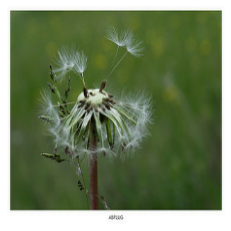

In [147]:
# Running the model to test the import has worked
taken = list(train_ds.take(2))
image = taken[0][0]
#img = tf.keras.preprocessing.load_img(img_path, target_size=(224, 224))
#x = tf.keras.preprocessing.img_to_array(img)

# Display the image
plt.imshow(image[0].numpy().astype("uint8"))
plt.axis("off")


x = tf.keras.applications.mobilenet_v3.preprocess_input(image)
preds = mobileNet.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', tf.keras.applications.mobilenet_v3.decode_predictions(preds)[0])

In [172]:
model = keras.models.Sequential()

# Adding mobilenet to the model
model.add(mobileNet)

# Now I'm going to train the last 3 layers of the model and freeze the rest
for layer in model.layers[:-10]:
	layer.trainable = False

# Adding new layers which will be trained
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=5, activation='softmax'))

# Training the model on the training dataset
model.compile(
	optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy']
)

model.fit(train_ds, epochs=2, validation_data=test_ds)

# Fine Tuning the model
for layer in model.layers:
	layer.trainable = True

model.compile(
	optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy']
)

model.fit(train_ds, epochs=8, validation_data=test_ds)
results = model.evaluate(test_ds)

print("test loss, test acc:", results)


	


Epoch 1/2
41/41 [==============================] - 64s 1s/step - loss: 1.2233 - accuracy: 0.5045 - val_loss: 1.4780 - val_accuracy: 0.5132
Epoch 2/2
41/41 [==============================] - 59s 1s/step - loss: 0.9935 - accuracy: 0.5851 - val_loss: 1.4436 - val_accuracy: 0.5359
Epoch 1/8
41/41 [==============================] - 62s 1s/step - loss: 0.9364 - accuracy: 0.6170 - val_loss: 1.4862 - val_accuracy: 0.5795
Epoch 2/8
41/41 [==============================] - 58s 1s/step - loss: 0.9018 - accuracy: 0.6302 - val_loss: 1.3041 - val_accuracy: 0.6340
Epoch 3/8
41/41 [==============================] - 57s 1s/step - loss: 0.8481 - accuracy: 0.6645 - val_loss: 1.1915 - val_accuracy: 0.6748
Epoch 4/8
41/41 [==============================] - 56s 1s/step - loss: 0.8430 - accuracy: 0.6555 - val_loss: 1.1521 - val_accuracy: 0.6821
Epoch 5/8
41/41 [==============================] - 54s 1s/step - loss: 0.8337 - accuracy: 0.6668 - val_loss: 1.1038 - val_accuracy: 0.7003
Epoch 6/8
41/41 [==========